In [1]:
# положить веса в лосс
# добавить части речи
# попробовать лосс который достаестя из output 
# обучать только классификатор и заморозить берт
# оставить скобочки но убрать их повторение

In [29]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from torch.optim import AdamW
from torch.utils import data
from sklearn import metrics
import torch.nn as nn
import pandas as pd
import numpy as np
import argparse
import logging
import random
import torch
import tqdm
import sys
import os

In [ ]:
# Config
PREDICTION_COLUMN = 'Экстраверсия'
SEED = 42
TOKENIZER_NAME = "DeepPavlov/rubert-base-cased"
MODEL_NAME = "DeepPavlov/rubert-base-cased"
LENGTH_THRESHOLD = 10
MAX_LENGTH = 80
FREEZE = False
BATCH_SIZE = 128
EPOCHS = 10
LR=1e-5

In [3]:
def seed_everything(seed_value=42):
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    return seed_value


logging.basicConfig(
        format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO
    )
logger = logging.getLogger(__name__)

In [32]:
dataset = pd.read_csv('../data/processed/df_tokens_ocean.csv')

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset['lengths'] = dataset.tokens.apply(lambda x: len(str(x).split()))
if LENGTH_THRESHOLD > 0:
    dataset = dataset.query('lengths > @LENGTH_THRESHOLD')

In [7]:
df = dataset[['tokens', PREDICTION_COLUMN]]
df[PREDICTION_COLUMN] = df[PREDICTION_COLUMN].apply(lambda x: int(x))
train_data, valid_data = train_test_split(df, test_size=0.33, stratify=df[PREDICTION_COLUMN], random_state=SEED)
valid_data, test_data = train_test_split(valid_data, test_size=0.5, stratify=valid_data[PREDICTION_COLUMN], random_state=SEED)

In [8]:
train_data.shape, valid_data.shape, test_data.shape

((3350, 2), (825, 2), (825, 2))

In [9]:
seed_everything(SEED)
logger.info(f"Training with seed {SEED}...")

num_classes = train_data[PREDICTION_COLUMN].nunique()
logger.info(f"We have {num_classes} classes")
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

2023-04-30 22:23:16,118 : INFO : Training with seed 42...
2023-04-30 22:23:16,120 : INFO : We have 4 classes


In [10]:
def encoder(labels, texts, cur_tokenizer, cur_device):
    labels_tensor = torch.tensor(labels, dtype=torch.long).to(cur_device)
    encoding = cur_tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
    ).to(cur_device)
    return labels_tensor, encoding

In [26]:
def create_ids_mask(dataset):
    texts = dataset.tokens.to_list()
    labels = dataset[PREDICTION_COLUMN].to_list()
    labels_tensor, encoding = encoder(labels, texts, tokenizer, device)
    input_ids = encoding["input_ids"]
    attention_mask = encoding["attention_mask"]

    return data.TensorDataset(input_ids, attention_mask, labels_tensor) 

logger.info(f"Tokenizing with max length {MAX_LENGTH}...")
train_dataset = create_ids_mask(train_data)
train_iter = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # TRUE !!!!!

dev_dataset = create_ids_mask(valid_data)
dev_iter = data.DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = create_ids_mask(test_data)
test_iter = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
logger.info("Tokenizing finished.")

2023-04-30 23:26:10,528 : INFO : Tokenizing with max length 16...
2023-04-30 23:26:10,915 : INFO : Tokenizing finished.


In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_classes
).to(device)
weights = [len(x) / len(df) for i, x in df.groupby(PREDICTION_COLUMN)]
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))
optimizer = AdamW(model.parameters(), lr=LR)

if FREEZE:
    logger.info("Freezing the model, training only the classifier on top")
    for param in model.base_model.parameters():
        param.requires_grad = False

plot_train_losses, plot_dev_losses = [], []

logger.info(f"Training with batch size {BATCH_SIZE} for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    print(f'---------------------------- Epoch {epoch+1} -----------------------------')
    # train
    print()
    model.train()
    train_losses = 0
    y_true_train, y_pred_train = [], []
    for input_ids, attention_mask, labels_tensor in tqdm.tqdm(train_iter):
        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids, attention_mask=attention_mask, labels=labels_tensor
        )
        loss = loss_fn(outputs.logits, labels_tensor)
        train_losses += loss.item()
        loss.backward()
        optimizer.step()
        batch_predictions = torch.log_softmax(outputs.logits, dim=1).argmax(dim=1)
        y_true_train += labels_tensor.tolist()
        y_pred_train += batch_predictions.tolist()
    accuracy_train = accuracy_score(y_true=y_true_train, y_pred=y_pred_train)
    f1_train = f1_score(y_true=y_true_train, y_pred=y_pred_train, average="macro")
    train_loss = train_losses / len(train_iter)
    plot_train_losses.append(train_loss)
    print(f'Train loss: {train_loss}')
    print(f'Train accuracy: {accuracy_train}')
    print(f'Train f1: {f1_train}')
    print()

    # validation
    model.eval()
    val_losses = 0
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for input_ids, attention_mask, labels_tensor in tqdm.tqdm(dev_iter):
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels_tensor)
            val_losses += loss.item()
            batch_predictions = torch.log_softmax(outputs.logits, dim=1).argmax(dim=1)
            y_true_val += labels_tensor.tolist()
            y_pred_val += batch_predictions.tolist()
    accuracy_dev = accuracy_score(y_true=y_true_val, y_pred=y_pred_val)
    f1_dev = f1_score(y_true=y_true_val, y_pred=y_pred_val, average="macro")
    val_loss = val_losses / len(dev_iter)
    plot_dev_losses.append(val_loss)
    print(f'Validation loss: {val_loss}')
    print(f'Validation accuracy: {accuracy_dev}')
    print(f'Validation f1: {f1_dev}')
    print(classification_report(y_true_val, y_pred_val))
    print()


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

---------------------------- Epoch 1 -----------------------------

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████| 838/838 [21:20<00:00,  1.53s/it]


Train loss: 1.278474917844258
Train accuracy: 0.3397014925373134
Train f1: 0.21324994398941258



100%|██████████| 207/207 [00:13<00:00, 15.49it/s]

Validation loss: 1.252950290262987
Validation accuracy: 0.37333333333333335
Validation f1: 0.2383850236507318
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.36      0.74      0.49       258
           2       0.40      0.43      0.41       262
           3       0.33      0.03      0.05       134

    accuracy                           0.37       825
   macro avg       0.27      0.30      0.24       825
weighted avg       0.29      0.37      0.29       825





/Users/annapalatkina/Desktop/THESIS/code/OCEAN_persinality_thesis/venv_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annapalatkina/Desktop/THESIS/code/OCEAN_persinality_thesis/venv_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annapalatkina/Desktop/THESIS/code/OCEAN_persinality_thesis/venv_3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with n

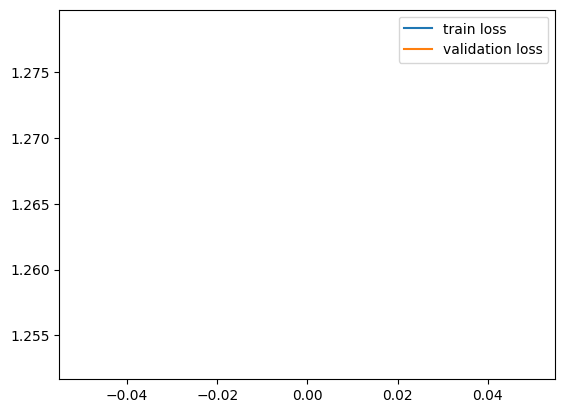

In [13]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# plot lines
plt.plot(plot_train_losses, label = "train loss")
plt.plot(plot_dev_losses, label = "validation loss")
plt.legend()
plt.show()

In [ ]:
# test
model.eval()
y_true_test, y_pred_test = [], []
with torch.no_grad():
    for input_ids, attention_mask, labels_tensor in tqdm.tqdm(test_iter):
        outputs = model(input_ids, attention_mask=attention_mask)
        batch_predictions = torch.log_softmax(outputs.logits, dim=1).argmax(dim=1)
        y_true_test += labels_tensor.tolist()
        y_pred_test += batch_predictions.tolist()
accuracy_test = accuracy_score(y_true=y_true_test, y_pred=y_pred_test)
f1_test = f1_score(y_true=y_true_test, y_pred=y_pred_test, average="macro")
print(f'Test accuracy: {accuracy_test}')
print(f'Test f1: {f1_test}')
print(classification_report(y_true_test, y_pred_test))
print()
